# Stellar Transient Populations 🔍

In this notebook, we will cover:
1. Selecting binaries and combining metallicities
2. Exploring the `TransientPopulation` class

We will do this in the context of the merging binary black hole population.

If you haven't done so yet, export the path POSYDON environment variables. For example:

In [ ]:
%env PATH_TO_POSYDON=/Users/simone/Google Drive/github/POSYDON-public/
%env PATH_TO_POSYDON_DATA=/Volumes/T7/

## Creating multi-metallicity Populations


<div class="alert alert-block alert-warning"><b>Reprocessed POSYDON v1 dataset</b> 

Please note that with the reprocessed POSYDON v1 data, only solar metallicity is available.
You will not be able to follow along with the full tutorial!
If you would still like to explore a population at solar metallicity, you can follow the "One metallicity" tutorial.</div>

In the previous tutorial, you generated 8 population files with 1000 binaries.
Since this is a small population of only 8.000 binaries, you could explore the complete population.
But the larger your populations get, the better it is to select specific binaries.

For each population file, we can export the binaries we're interested in into a new file.
For this, we need to find the indices of the merging binaries. The relevant properties are that both S1_state and S2_state equal 'BH', while the binary has the `event == 'CO_contact`.

We will load one of the population files to build our merging binaries selection.



<div class="alert alert-block alert-warning"><b>No indices?</b> 

It might be that the population you generated does not contain any merging BBHs, they're rare after all.

As such, we have provided an example population run at `$PATH_TO_POSYDON_DATA/population-synthesis/example/`, this simulation contains 10.000 binaries at the 8 metallicity. </div>


In [6]:
from posydon.popsyn.synthetic_population import Population

pop = Population('1e+00_Zsun_population.h5') 
tmp_data = pop.history.select(columns=['S1_state', 'S2_state', 'event'])


`pop.history.select` is a read operation on the population file and can take quite a lot of time if the population is large.

If you have sufficient memory, it is more efficient to select several columns at the same time, as done here, instead of selecting a single column each time.

In [7]:
# Selection of S1 being a BH
S1_state = tmp_data['S1_state'] == 'BH'
# Selection of S2 being a BH
S2_state = tmp_data['S2_state'] == 'BH'
# Selection of the binary system being in contact during the double CO phase.
state = tmp_data['event'] == 'CO_contact'

# get the indices of all systems
indices = tmp_data.index

# delete the temporary data
del tmp_data

# get a mask for the indices that satisfy all the conditions
mask = S1_state & S2_state & state

# get the indices that satisfy all the conditions
selected_indices = indices[mask].to_list()

The `selected_indices` has to be a list for the selection to work correctly.

You can test you selection by doing the following:

In [8]:
print(selected_indices)
pop.history[selected_indices]

[]


""


If your selected indices is empty, no BBH mergers were in your population.

Lets use an example set of populations to make sure there will be BBH in your population.

**This can only be used with the multi-metallicity populations**

In [9]:
from posydon.popsyn.synthetic_population import Population

PATH_TO_POSYDON_DATA = '/Users/max/Documents/POSYDON_data/240305/POSYDON_data/tutorials/population-synthesis/example/'

files = ['1e-01_Zsun_population.h5',
         '1e-02_Zsun_population.h5',
         '1e-03_Zsun_population.h5',
         '1e-04_Zsun_population.h5',
         '1e+00_Zsun_population.h5',
         '2e-01_Zsun_population.h5',
         '2e+00_Zsun_population.h5',
         '4.5e-01_Zsun_population.h5']


pop = Population(PATH_TO_POSYDON_DATA+files[0])

In [10]:
pop.history

,state,event,time,orbital_period,eccentricity,lg_mtransfer_rate,step_names,step_times,S1_state,S1_mass,...,S2_he_core_mass,S2_he_core_radius,S2_co_core_mass,S2_co_core_radius,S2_center_h1,S2_center_he4,S2_surface_h1,S2_surface_he4,S2_surf_avg_omega_div_omega_crit,S2_spin
binary_index,,,,,,,,,,,,,,,,,,,,,
600,detached,ZAMS,0.000000e+00,1.055730,0.0,NaN,initial_cond,0.000000,H-rich_Core_H_burning,51.658001,...,NaN,NaN,NaN,NaN,0.747480,0.251100,NaN,NaN,NaN,NaN
600,contact,oCE1,4.236171e+05,0.827391,0.0,-2.792667,step_HMS_HMS,0.153432,H-rich_Core_H_burning,50.343884,...,0.0,0.0,0.0,0.0,0.732523,0.266098,0.744122,0.254440,0.807113,11.503428
600,merged,oMerging1,4.236171e+05,0.827391,0.0,-2.792667,step_CE,0.000055,H-rich_Core_H_burning,50.343884,...,0.0,0.0,0.0,0.0,0.732523,0.266098,0.744122,0.254440,0.807113,11.503428
600,merged,CC1,4.344205e+06,NaN,NaN,NaN,step_merged,2.824777,H-rich_Central_C_depletion,37.918712,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
600,merged,NaN,4.344205e+06,NaN,NaN,NaN,step_SN,0.074564,BH,33.785929,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1799,contact,oCE1,1.352121e+06,0.474735,0.0,-4.587793,step_HMS_HMS,0.032689,H-rich_Core_H_burning,15.878279,...,0.0,0.0,0.0,0.0,0.746750,0.251716,0.747438,0.251114,0.543626,8.703293
1799,merged,oMerging1,1.352121e+06,0.474735,0.0,-4.587793,step_CE,0.000059,H-rich_Core_H_burning,15.878279,...,0.0,0.0,0.0,0.0,0.746750,0.251716,0.747438,0.251114,0.543626,8.703293
1799,merged,CC1,1.475450e+07,NaN,NaN,NaN,step_merged,0.585972,H-rich_Central_C_depletion,10.997112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We don't just want to write these binaries for a single metallicity. We want to export them for each metallicity file.
As such, we loop over each Population file and export the binaries to the same file. It's important to have the same columns in the populations, otherwise it's not possible to add them together.

The indices of the binaries will be reset, when being exported, such that the new file contains unique indices for each binary.

In [11]:
from posydon.popsyn.synthetic_population import Population
# The names of the populations, if you followed along.
files = ['1e-01_Zsun_population.h5',
         '1e-02_Zsun_population.h5',
         '1e-03_Zsun_population.h5',
         '1e-04_Zsun_population.h5',
         '1e+00_Zsun_population.h5',
         '2e-01_Zsun_population.h5',
         '2e+00_Zsun_population.h5',
         '4.5e-01_Zsun_population.h5']


for file in files:
    pop = Population(PATH_TO_POSYDON_DATA+file)
    # read the relevant data in one go
    # (faster than reading it in chunks, but requires more memory)
    tmp_data = pop.history.select(columns=['S1_state', 'S2_state', 'event'])
    # Selection of S1 being a BH
    S1_state = tmp_data['S1_state'] == 'BH'
    # Selection of S2 being a BH
    S2_state = tmp_data['S2_state'] == 'BH'
    # Selection of the binary system being in contact during the double CO phase.
    state = tmp_data['event'] == 'CO_contact'
    indices = tmp_data.index
    del tmp_data
    mask = S1_state & S2_state & state
    selected_indices = indices[mask].to_list()
    print(f'File: {file}, Number of systems: {len(selected_indices)}')
    
    # set overwrite to False to add to the file
    pop.export_selection(selected_indices, 'BBH_contact.h5', append=True)

File: 1e-01_Zsun_population.h5, Number of systems: 21
File: 1e-02_Zsun_population.h5, Number of systems: 52
File: 1e-03_Zsun_population.h5, Number of systems: 115
File: 1e-04_Zsun_population.h5, Number of systems: 109
File: 1e+00_Zsun_population.h5, Number of systems: 1
File: 2e-01_Zsun_population.h5, Number of systems: 17
File: 2e+00_Zsun_population.h5, Number of systems: 0
File: 4.5e-01_Zsun_population.h5, Number of systems: 3


If you population did not contain any BBH mergers, all the "Number of Systems" will be 0 and you won't be able to open the file in the next cell.

If you ran the population with the tutorial populations, you should have a total of 636 merging BBHs.

We can confirm this by adding up the values above or by opening the new file. `Population.number_of_systems` gives us the total number of binaries in the file. 

You now see that the `mass_per_met` property contains information about all the metallicities in the file.

You can even combined multiple runs at the same metallicity together, if you like. This will combine their simualted and underlying masses.

In [13]:
from posydon.popsyn.synthetic_population import Population
BBH_pop = Population('BBH_contact.h5', chunksize=10000)
print(BBH_pop.number_of_systems)

BBH_pop.mass_per_metallicity

636


,simulated_mass,underlying_mass,number_of_systems
0.0001,562429.989797,3.163009e+06,218
0.0010,566289.865867,3.184716e+06,230
0.0100,566213.739304,3.184288e+06,104
0.1000,563839.142847,3.170933e+06,42
0.2000,564120.804491,3.172517e+06,34
0.4500,564642.481110,3.175451e+06,6
1.0000,565427.223154,3.179864e+06,2
2.0000,568264.457386,3.195821e+06,0


# Transient population

Although we now have selected all binaries with a BBH merger, we don't have the extact moment of the merger yet.

For this we will create a `TransientPopulation`.
This class is used to hold information about a specific event/moment in time.

In our case, this is the moment of "CO_contact". However, we might want to store 
and calculate some additional values, such as the $M_\mathrm{chirp}$ or $\chi_\mathrm{eff}$.

The `Population` class has a function `create_transient_population` (see [here for more details]()).

In short, it takes a `selection_function` and a `transient_name`.

The `transient_name` is a string identifying the transient population in the file,
while `selection_function` extracts the `TransientPopulation` for us.
This can be any custom function you want it to be, as long it outputs a pandas DataFrame with a 'time' and 'metallicity' column.

Several selection functions are provided in `posydon.popsyn.transient_select_funcs`:
1. BBH_selection_function
2. GRB_selection_function

We have copied part of the BBH_selection_function below to explain how a `selections_function` works.

In [14]:
import pandas as pd
def BBH_selection_function(history_chunk, oneline_chunk, formation_channels_chunk):
    '''A BBH selection function to create a transient population of BBHs mergers.'''
    
    indices = oneline_chunk.index.to_numpy()
    df_transients = pd.DataFrame(index = indices)
    
    df_transients['time'] = history_chunk[history_chunk['event'] == 'CO_contact']['time'] * 1e-6 #Myr
    df_transients['metallicity'] = oneline_chunk['metallicity']

    return df_transients

A `selection_function` always has as an input a chunk of the history, oneline, and formation_pathways (optional).
For example, you set your `chunksize=10` when you initialise the `Population`, like we've done above for `BBH_pop`, each chunk will contain 10 binaries.
This means that the complete history, oneline and formation_pathways of those 10 binaries are passed to this function.


The `BBH_selection_function` selects the moment the binary reaches CO_contact as the moment of merger, and stores it in the `time` columns in Myr.
The metallicity is also outputted.

We can test this function by inputting a single binary into it, as done below.
If you've used the example populations, you might not have calculated the formation_channels yet. We will set that input to None.

In [15]:
BBH_selection_function(BBH_pop.history[0], BBH_pop.oneline[0], None)

,time,metallicity
0,3882.534971,0.1


This gives us a dataframe containing our 1 binary, its index (0), the moment of merger, and its metallicity.
Of course, we could like to know a bit more about our merger than just when it occurs.

Lets expand our output with the BH masses, their spin, their tilt, and the orbital period at DCO formation.

In [16]:
def BBH_selection_function(history_chunk, oneline_chunk, formation_channels_chunk):
    '''A BBH selection function to create a transient population of BBHs mergers.'''
    
    indices = oneline_chunk.index.to_numpy()
    df_transients = pd.DataFrame(index = indices)
    
    df_transients['time'] = history_chunk[history_chunk['event'] == 'CO_contact']['time'] * 1e-6 #Myr
    df_transients['metallicity'] = oneline_chunk['metallicity']
    
    # Added properties
    mask = (history_chunk['S1_state'] == 'BH') & (history_chunk['S2_state'] == 'BH') & (history_chunk['step_names'] == 'step_SN') & (history_chunk['state'] == 'detached')
    df_transients['t_inspiral'] = df_transients['time'] - history_chunk[mask]['time']*1e-6
    df_transients['S1_state']  = history_chunk[mask]['S1_state']
    df_transients['S2_state']  = history_chunk[mask]['S2_state']
    df_transients['S1_mass'] = history_chunk[mask]['S1_mass']
    df_transients['S2_mass'] = history_chunk[mask]['S2_mass']
    df_transients['S1_spin'] = history_chunk[mask]['S1_spin']
    df_transients['S2_spin'] = history_chunk[mask]['S2_spin']
    df_transients['S1_spin_orbit_tilt'] = oneline_chunk['S1_spin_orbit_tilt']
    df_transients['S2_spin_orbit_tilt'] = oneline_chunk['S2_spin_orbit_tilt']
    df_transients['orbital_period'] = history_chunk[mask]['orbital_period']
    
    return df_transients

In [17]:
BBH_selection_function(BBH_pop.history[0], BBH_pop.oneline[0], None)

,time,metallicity,t_inspiral,S1_state,S2_state,S1_mass,S2_mass,S1_spin,S2_spin,S1_spin_orbit_tilt,S2_spin_orbit_tilt,orbital_period
0,3882.534971,0.1,3874.942673,BH,BH,15.677029,19.554355,0.130716,0.20363,0.078556,0.056097,2.177576


With this new function, we have a lot more information available in the TransientPopulation.

You can further customise this to your liking, if you want to store specific information.
It's also possible to calculate additional infomration based on any value in the history, oneline or formation_channels.

We will import some functions to calculate $\chi_\mathrm{eff}$, $q$ and $\mathcal{M}_\mathrm{chirp}$ and also add them to the dataframe.


In [18]:
from posydon.popsyn.transient_select_funcs import chi_eff, mass_ratio, m_chirp
import pandas as pd

def BBH_selection_function(history_chunk, oneline_chunk, formation_channels_chunk):
    '''A BBH selection function to create a transient population of BBHs mergers.'''
    
    indices = oneline_chunk.index.to_numpy()
    df_transients = pd.DataFrame(index = indices)
    
    df_transients['time'] = history_chunk[history_chunk['event'] == 'CO_contact']['time'] * 1e-6 #Myr
    mask = (history_chunk['S1_state'] == 'BH') & (history_chunk['S2_state'] == 'BH') & (history_chunk['step_names'] == 'step_SN') & (history_chunk['state'] == 'detached')
    df_transients['metallicity'] = oneline_chunk['metallicity']
    df_transients['t_inspiral'] = df_transients['time'] - history_chunk[mask]['time']*1e-6
    
    df_transients['S1_state']  = history_chunk[mask]['S1_state']
    df_transients['S2_state']  = history_chunk[mask]['S2_state']
    df_transients['S1_mass'] = history_chunk[mask]['S1_mass']
    df_transients['S2_mass'] = history_chunk[mask]['S2_mass']
    df_transients['S1_spin'] = history_chunk[mask]['S1_spin']
    df_transients['S2_spin'] = history_chunk[mask]['S2_spin']
    df_transients['S1_spin_orbit_tilt'] = oneline_chunk['S1_spin_orbit_tilt']
    df_transients['S2_spin_orbit_tilt'] = oneline_chunk['S2_spin_orbit_tilt']
    df_transients['orbital_period'] = history_chunk[mask]['orbital_period']
    df_transients['eccentricity'] = history_chunk[mask]['eccentricity']
    
    # Added
    df_transients['chirp_mass'] = m_chirp(history_chunk[mask]['S1_mass'], history_chunk[mask]['S2_mass'])
    df_transients['mass_ratio'] = mass_ratio(history_chunk[mask]['S1_mass'], history_chunk[mask]['S2_mass'])
    df_transients['chi_eff'] = chi_eff(history_chunk[mask]['S1_mass'], history_chunk[mask]['S2_mass'], history_chunk[mask]['S1_spin'], history_chunk[mask]['S2_spin'], oneline_chunk['S1_spin_orbit_tilt'], oneline_chunk['S2_spin_orbit_tilt'])
    
    return df_transients

In [19]:
BBH_selection_function(BBH_pop.history[0], BBH_pop.oneline[0], None)

,time,metallicity,t_inspiral,S1_state,S2_state,S1_mass,S2_mass,S1_spin,S2_spin,S1_spin_orbit_tilt,S2_spin_orbit_tilt,orbital_period,eccentricity,chirp_mass,mass_ratio,chi_eff
0,3882.534971,0.1,3874.942673,BH,BH,15.677029,19.554355,0.130716,0.20363,0.078556,0.056097,2.177576,0.096325,15.223637,0.801715,0.170828


Before running this selection on the whole population, we would like to include the formation_channels too.
First, we calculate them for the population:

In [20]:
BBH_pop.calculate_formation_channels(mt_history=True)

Now we can include the formation_channels in `df_transients`.

In [21]:
def BBH_selection_function(history_chunk, oneline_chunk, formation_channels_chunk):
    '''A BBH selection function to create a transient population of BBHs mergers.'''
    
    indices = oneline_chunk.index.to_numpy()
    df_transients = pd.DataFrame(index = indices)
    
    df_transients['time'] = history_chunk[history_chunk['event'] == 'CO_contact']['time'] * 1e-6 #Myr
    mask = (history_chunk['S1_state'] == 'BH') & (history_chunk['S2_state'] == 'BH') & (history_chunk['step_names'] == 'step_SN') & (history_chunk['state'] == 'detached')
    df_transients['metallicity'] = oneline_chunk['metallicity']
    df_transients['t_inspiral'] = df_transients['time'] - history_chunk[mask]['time']*1e-6
    
    df_transients['S1_state']  = history_chunk[mask]['S1_state']
    df_transients['S2_state']  = history_chunk[mask]['S2_state']
    df_transients['S1_mass'] = history_chunk[mask]['S1_mass']
    df_transients['S2_mass'] = history_chunk[mask]['S2_mass']
    df_transients['S1_spin'] = history_chunk[mask]['S1_spin']
    df_transients['S2_spin'] = history_chunk[mask]['S2_spin']
    df_transients['S1_spin_orbit_tilt'] = oneline_chunk['S1_spin_orbit_tilt']
    df_transients['S2_spin_orbit_tilt'] = oneline_chunk['S2_spin_orbit_tilt']
    df_transients['orbital_period'] = history_chunk[mask]['orbital_period']
    df_transients['eccentricity'] = history_chunk[mask]['eccentricity']
    
    df_transients['chirp_mass'] = m_chirp(history_chunk[mask]['S1_mass'], history_chunk[mask]['S2_mass'])
    df_transients['mass_ratio'] = mass_ratio(history_chunk[mask]['S1_mass'], history_chunk[mask]['S2_mass'])
    df_transients['chi_eff'] = chi_eff(history_chunk[mask]['S1_mass'], history_chunk[mask]['S2_mass'], history_chunk[mask]['S1_spin'], history_chunk[mask]['S2_spin'], oneline_chunk['S1_spin_orbit_tilt'], oneline_chunk['S2_spin_orbit_tilt'])
    
    # added
    df_transients = pd.concat([df_transients, formation_channels_chunk[['channel']]], axis=1)    
    
    return df_transients


In [22]:
# NOTE: the formation channels have to be given as a dataframe, as such we call it with loc[[0]] for testing
BBH_selection_function(BBH_pop.history[0], BBH_pop.oneline[0], BBH_pop.formation_channels.loc[[0]])

,time,metallicity,t_inspiral,S1_state,S2_state,S1_mass,S2_mass,S1_spin,S2_spin,S1_spin_orbit_tilt,S2_spin_orbit_tilt,orbital_period,eccentricity,chirp_mass,mass_ratio,chi_eff,channel
0,3882.534971,0.1,3874.942673,BH,BH,15.677029,19.554355,0.130716,0.20363,0.078556,0.056097,2.177576,0.096325,15.223637,0.801715,0.170828,ZAMS_oRLO1-contact_CC1_oRLO2_CC2_END


The example binary gives us a dataframe with all the information we're interested in. But if somehting is missing feel free to customize the selection further!

We now create the transient population with the `BBH_selection_function`, we've created and `create_transient_population`.

This will create a `TransientPopulation` instance and write the transient population to the current file.

`BBH_mergers.population` will load the complete dataframe we've just created. Each of the indices in this population refer back to the original binaries, which are still accessible through `BBH_mergers.history` or `BBH_mergers.oneline`.

In [23]:
BBH_mergers = BBH_pop.create_transient_population(BBH_selection_function, 'BBH')

In [24]:
BBH_mergers.population

,time,metallicity,t_inspiral,S1_state,S2_state,S1_mass,S2_mass,S1_spin,S2_spin,S1_spin_orbit_tilt,S2_spin_orbit_tilt,orbital_period,eccentricity,chirp_mass,mass_ratio,chi_eff,channel
0,3882.534971,0.10,3874.942673,BH,BH,15.677029,19.554355,0.130716,0.203630,0.078556,0.056097,2.177576,0.096325,15.223637,0.801715,0.170828,ZAMS_oRLO1-contact_CC1_oRLO2_CC2_END
1,7465.288364,0.10,7454.728922,BH,BH,19.070653,21.130821,0.156158,0.170088,0.003403,0.006794,2.999552,0.033873,17.471121,0.902504,0.163477,ZAMS_oRLO1-contact_CC1_oRLO2_CC2_END
2,9807.932214,0.10,9800.645640,BH,BH,25.108658,15.951450,0.182752,0.125327,0.003482,0.082397,3.650896,0.266742,17.333656,0.635297,0.160277,ZAMS_oRLO1_CC1_oRLO2_CC2_END
3,5013.854890,0.10,5007.823067,BH,BH,29.102524,23.411723,0.172777,0.159647,0.020279,0.029768,3.105157,0.125832,22.696714,0.804457,0.166873,ZAMS_oRLO1-contact_CC1_oRLO2_CC2_END
4,11736.560843,0.10,11728.175138,BH,BH,17.567117,13.764029,0.183486,0.173543,0.061024,0.031152,3.024385,0.014148,13.516753,0.783511,0.178890,ZAMS_oRLO1-contact_CC1_oRLO2_CC2_END
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,12526.275203,0.20,12520.981623,BH,BH,19.709748,19.398561,0.198006,0.192267,0.065771,0.003400,3.639098,0.110013,17.022233,0.984212,0.194943,ZAMS_oRLO1-contact_CC1_oRLO2_CC2_END
632,117.881726,0.20,112.353000,BH,BH,24.939398,11.843030,0.015353,0.553808,0.097033,0.080998,0.566443,0.098140,14.759824,0.474872,0.188088,ZAMS_oRLO1_CC1_oRLO2_oCE2_CC2_END
633,9102.974552,0.45,9094.564319,BH,BH,23.259153,11.341739,0.000644,0.000280,0.152448,0.723646,942.123292,0.994763,13.961969,0.487625,0.000497,ZAMS_oRLO1_CC1_oRLO2_CC2_END
634,157.150618,0.45,150.573263,BH,BH,18.825632,9.774547,0.002249,0.548046,0.058161,0.007497,0.545011,0.088919,11.685142,0.519215,0.188775,ZAMS_oRLO1_CC1_oRLO2_oCE2_CC2_END


Since the TransienPopulation is stored in file, you can continue your analysis by opening the file using the `TransientPopulation` class.
You only need to do your selection once.

In [2]:
from posydon.popsyn.synthetic_population import TransientPopulation

BBH_mergers = TransientPopulation(filename='BBH_contact.h5', transient_name='BBH')

In [3]:
BBH_mergers.mass_per_metallicity

,simulated_mass,underlying_mass,number_of_systems
0.0001,562429.989797,3.163009e+06,218
0.0010,566289.865867,3.184716e+06,230
0.0100,566213.739304,3.184288e+06,104
0.1000,563839.142847,3.170933e+06,42
0.2000,564120.804491,3.172517e+06,34
0.4500,564642.481110,3.175451e+06,6
1.0000,565427.223154,3.179864e+06,2
2.0000,568264.457386,3.195821e+06,0


With `TransientPopulation` class you can compute the efficiency of the transient population at a given metallicity, i.e. the number of merging DCO per unit star formation and visualize the results.

In [4]:
BBH_mergers.get_efficiency_over_metallicity()

Efficiencies already computed! Overwriting them!
Efficiency at Z=1.00E-04: 6.89E-05 Msun^-1
Efficiency at Z=1.00E-03: 7.22E-05 Msun^-1
Efficiency at Z=1.00E-02: 3.27E-05 Msun^-1
Efficiency at Z=1.00E-01: 1.32E-05 Msun^-1
Efficiency at Z=2.00E-01: 1.07E-05 Msun^-1
Efficiency at Z=4.50E-01: 1.89E-06 Msun^-1
Efficiency at Z=1.00E+00: 6.29E-07 Msun^-1
Efficiency at Z=2.00E+00: 0.00E+00 Msun^-1


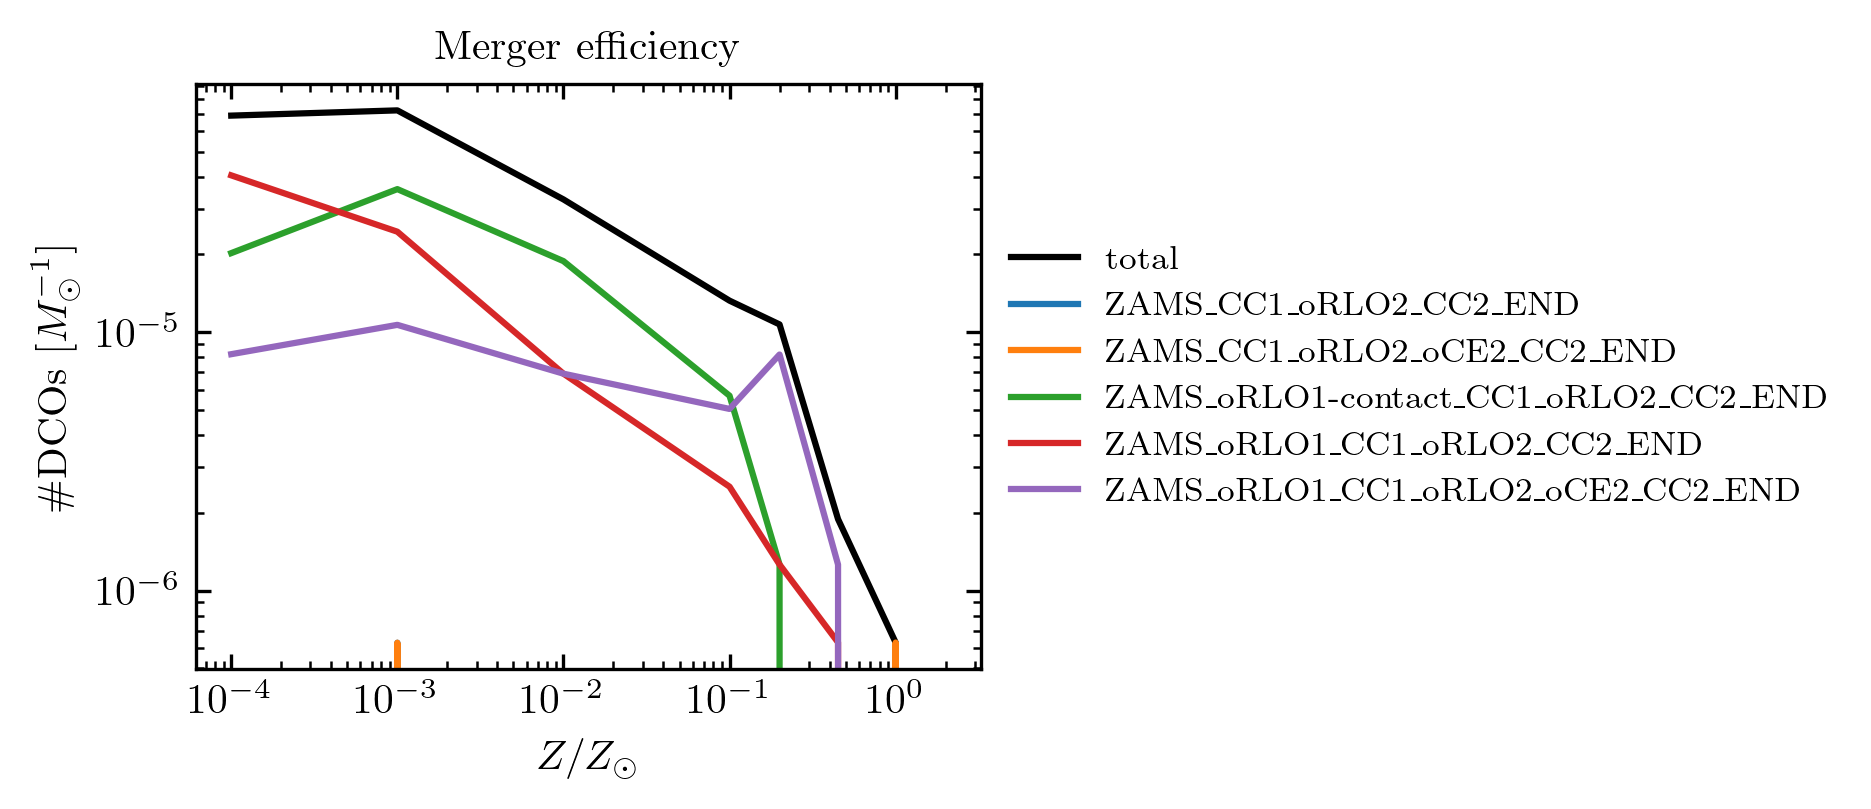

In [8]:
# if you want to plot the channels, you can set channels=True
BBH_mergers.plot_efficiency_over_metallicity(channels=True)

In [9]:
BBH_mergers.efficiency

,total,ZAMS_CC1_oRLO2_CC2_END,ZAMS_CC1_oRLO2_oCE2_CC2_END,ZAMS_oRLO1-contact_CC1_oRLO2_CC2_END,ZAMS_oRLO1_CC1_oRLO2_CC2_END,ZAMS_oRLO1_CC1_oRLO2_oCE2_CC2_END
metallicity,,,,,,
0.0001,6.892172e-05,0.000000e+00,0.000000e+00,0.000020,4.046780e-05,0.000008
0.0010,7.221994e-05,6.279995e-07,6.279995e-07,0.000036,2.449198e-05,0.000011
0.0100,3.266037e-05,0.000000e+00,0.000000e+00,0.000019,6.908923e-06,0.000007
0.1000,1.324531e-05,0.000000e+00,0.000000e+00,0.000006,2.522916e-06,0.000005
0.2000,1.071704e-05,0.000000e+00,0.000000e+00,0.000001,1.260828e-06,0.000008
0.4500,1.889495e-06,0.000000e+00,0.000000e+00,0.000000,6.298317e-07,0.000001
1.0000,6.289576e-07,0.000000e+00,6.289576e-07,0.000000,0.000000e+00,0.000000
2.0000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000


You can also plot the delay time distribution based on the time columns in the TransientPopulation.


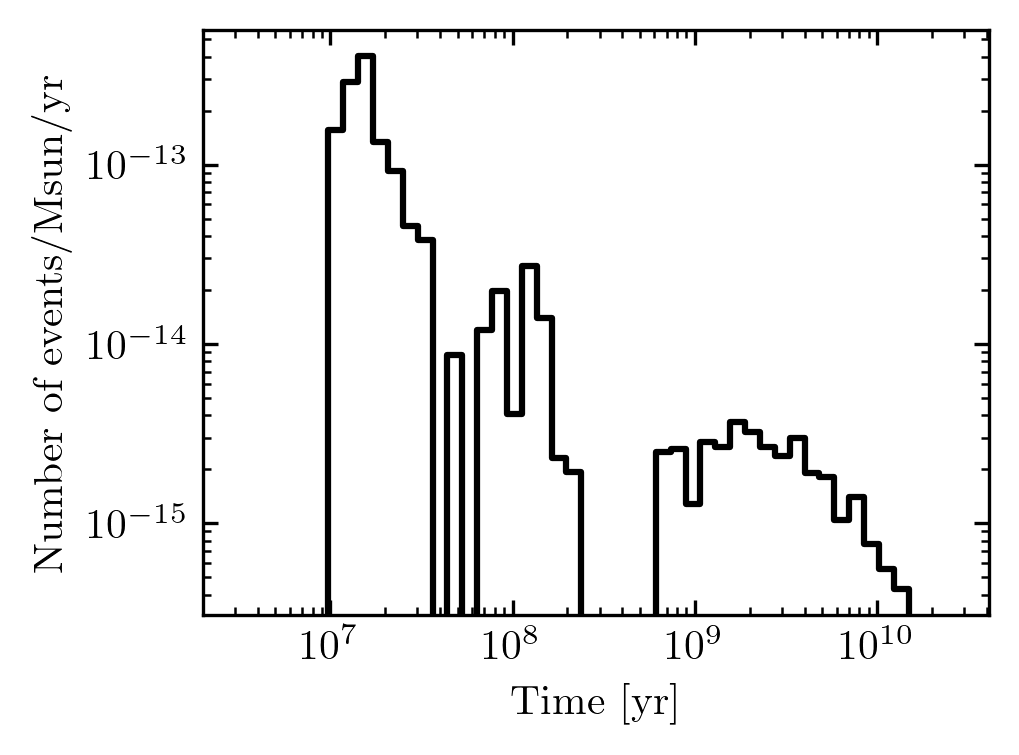

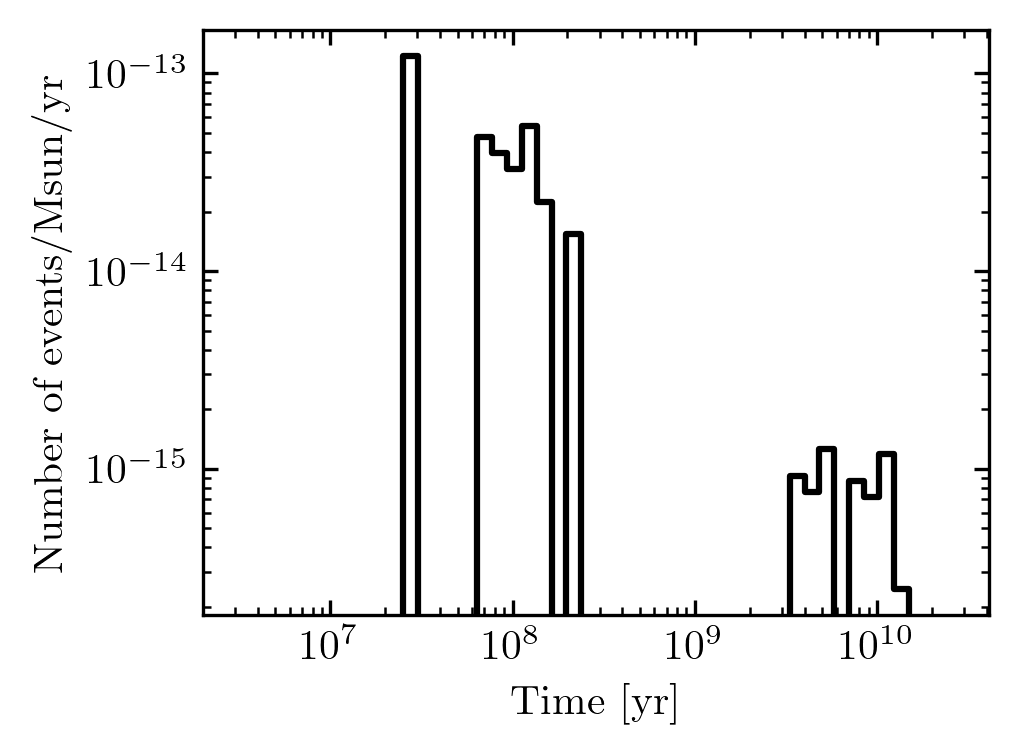

In [10]:
import matplotlib.pyplot as plt 
import numpy as np
bins = np.logspace(6.5,10.5)
BBH_mergers.plot_delay_time_distribution(bins=bins)
# you can also set a specific metallicity. However, this normalises the rate with only the mass of the selected metallicity.
BBH_mergers.plot_delay_time_distribution(metallicity=0.1, bins=bins)

You  might also be interested in seeing the evolution of the binary in more detail.

Therefore, you can plot the TransientPopulation over a grid slice.
For example, below we plot binaries over the $q=0.7$ slice at $Z=10^{-4} Z_\odot$ on the HMS-HMS grid.

If no slice is give, all mass ratios are plotted.

You can also plot a property from the TransientPopulation DataFrame as a colourmap.
And specific formation_channels if they're in the DataFrame.

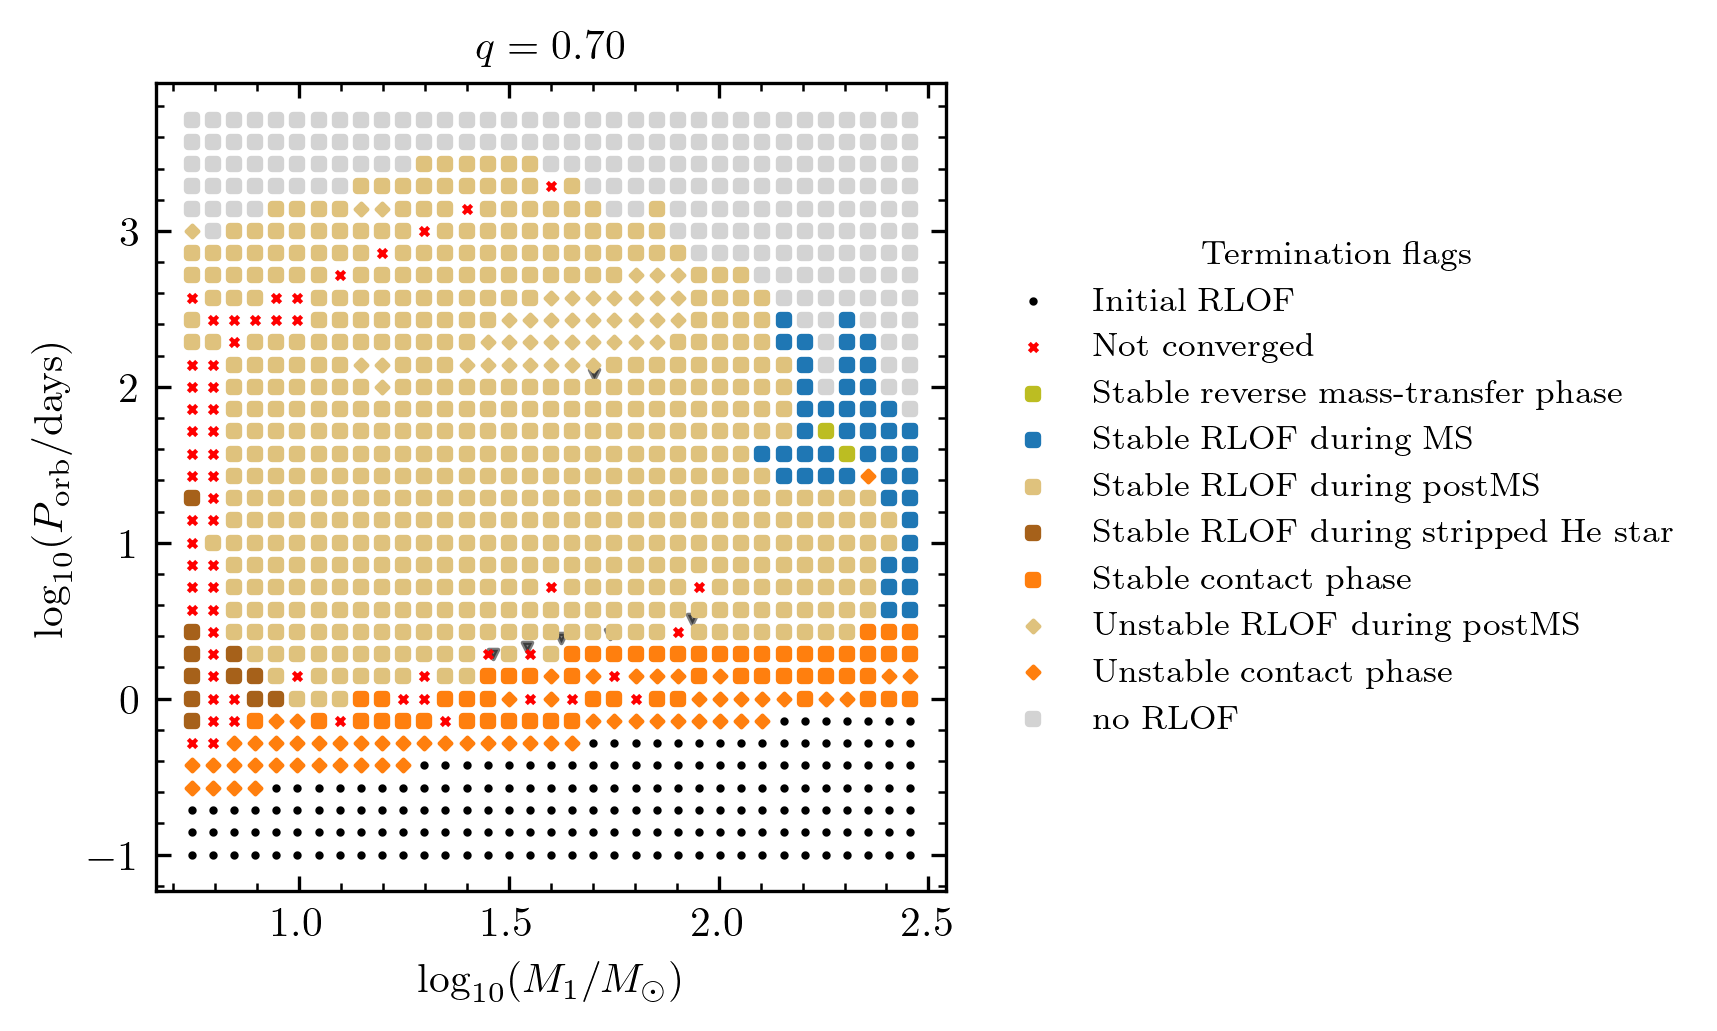

In [36]:
BBH_mergers.plot_popsyn_over_grid_slice('HMS-HMS', 1e-4, slices=[0.7], save_fig=False)

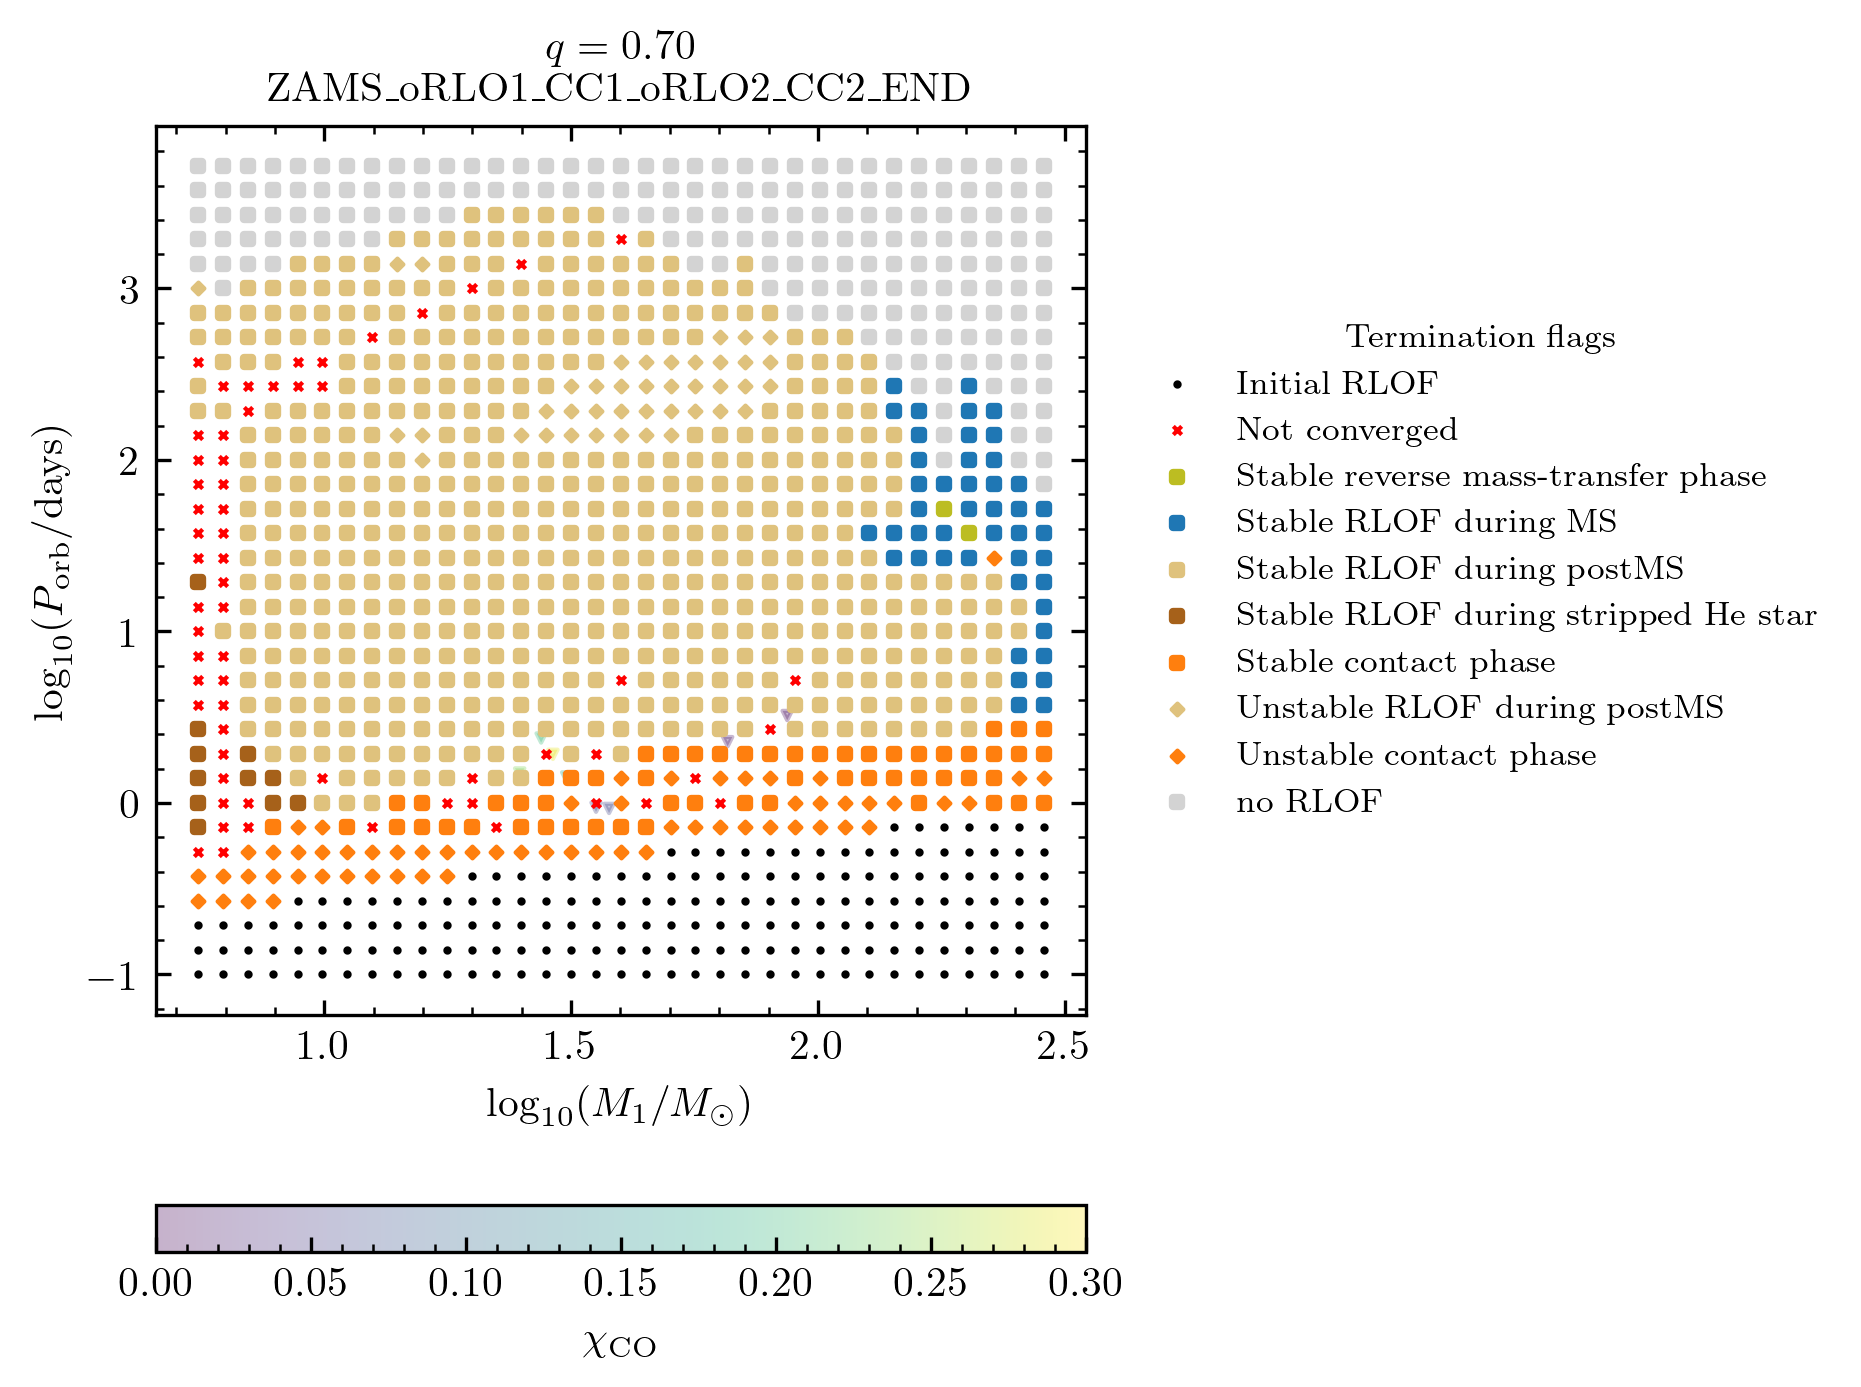

In [37]:
BBH_mergers.plot_popsyn_over_grid_slice('HMS-HMS', 1e-4, slices=[0.7], prop='S1_spin', prop_range=[0,0.3], save_fig=False, channel='ZAMS_oRLO1_CC1_oRLO2_CC2_END') # SMT channel

## Cosmic Rate

So far these events do not consider the metallicity or star formation rate evolution of the Universe.

POSYDON comes with several built-in star formation histories and metallicity evolutions, a few examples are:
- IllustrisTNG
- Neijssel2019
- Madau+Fragos2017

We can apply these to our population with the `calculate_cosmic_weights` function.
Here, we will the metallicity and SFR evolution of the IllustrisTNG, which is the default model used, if no `MODEL_in` is given.

The function returns an instance of the `Rates` class, which gives us access to some new variables:
- `z_birth`: the redshift and age of the universe at which we probe the star formation
- `z_events`: the redshift at which an event takes place
- `weights`: the weight of the event based on the SFR, its metallicity, and its weight in the population.

In [1]:
from posydon.popsyn.synthetic_population import TransientPopulation
BBH_mergers = TransientPopulation(filename='BBH_contact.h5', transient_name='BBH')

In [2]:
MODEL = {
    'delta_t' : 100, # Myr
    'SFR' : 'IllustrisTNG', # Neijssel2019, Madau+Fragos2017
    'sigma_SFR' : None,
    'Z_max' : 2.,
}

rates = BBH_mergers.calculate_cosmic_weights('IllustrisTNG', MODEL_in=MODEL)

/Users/max/Documents/POSYDON/posydon/popsyn/synthetic_population.py:2171: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['SFR', 'sigma_SFR', 'dlogZ'], dtype='object')]

  store.put(path_in_file + "MODEL", pd.DataFrame(MODEL, index=[0]))


In [3]:
rates.z_birth.head(2)

,z,t
0,0.003473,13.747616
1,0.010472,13.647616


In [4]:
rates.z_events.head(2)

,0,1,2,3,4,5,6,7,8,9,...,128,129,130,131,132,133,134,135,136,137
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.296171,1.330228,1.365456,1.401924,1.439707,1.478886,1.519549,1.561790,1.605715,1.651437
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.526581,0.540859,0.555398,0.570206,0.585291,0.600662,0.616331,0.632306,0.648599,0.665220


In [5]:
rates.weights.head(2)

,0,1,2,3,4,5,6,7,8,9,...,128,129,130,131,132,133,134,135,136,137
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.348396,11.862118,8.373666,6.268266,4.032299,1.929935,0.433681,0.006981,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.830019,2.991404,2.134316,1.613983,1.048326,0.506368,0.114780,0.001863,0.0,0.0


The rates can also be accessed using the `Rates` class. You will need to provide your transient_name and SFH_identifier.
You can keep as many transients and SFHs in your file as you like.

In [1]:
%load_ext autoreload

%autoreload 2
from posydon.popsyn.synthetic_population import Rates

rates = Rates(filename='BBH_contact.h5', transient_name='BBH', SFH_identifier='IllustrisTNG')

You can directly work with the weights and the z_events to get events at specific redshifts.

Or you can calculate the rate density over redshift using the `calculate_intrinsic_rate_density` function.
This will calculate the rate over redshift for you.

You can use the output of the function immediately, or get them from `rates.intrinsic_rate_density`.

In [7]:
out = rates.calculate_intrinsic_rate_density(mt_channels=True)

/Users/max/Documents/POSYDON/posydon/popsyn/synthetic_population.py:2413: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->floating,key->block1_values] [items->Index(['total'], dtype='object')]

  store.put(self.base_path + "intrinsic_rate_density", intrinsic_rate_density)


In [2]:
rates.intrinsic_rate_density

,total,ZAMS_CC1_oRLO2_CC2_END,ZAMS_CC1_oRLO2_oCE2_CC2_END,ZAMS_oRLO1-contact_CC1_oRLO2_CC2_END,ZAMS_oRLO1_CC1_oRLO2_CC2_END,ZAMS_oRLO1_CC1_oRLO2_oCE2_CC2_END
0.000000,66.195397,0.000248,0.394024,21.117311,33.786861,10.896953
0.006963,78.042396,0.000241,2.432461,25.440933,39.992862,10.175899
0.013998,80.696008,0.000354,3.089109,26.266783,41.254457,10.085304
0.021105,81.997473,0.000190,3.438145,26.197369,42.156904,10.204866
0.028287,82.708591,0.000261,3.640193,25.701286,43.065592,10.301258
...,...,...,...,...,...,...
9.627349,21.247522,0.000000,0.088935,0.000000,0.218625,20.939963
11.337550,7.302197,0.000000,0.015941,0.000000,0.065639,7.220617
13.957133,0.701934,0.000000,0.001978,0.000000,0.003985,0.695970
18.630504,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


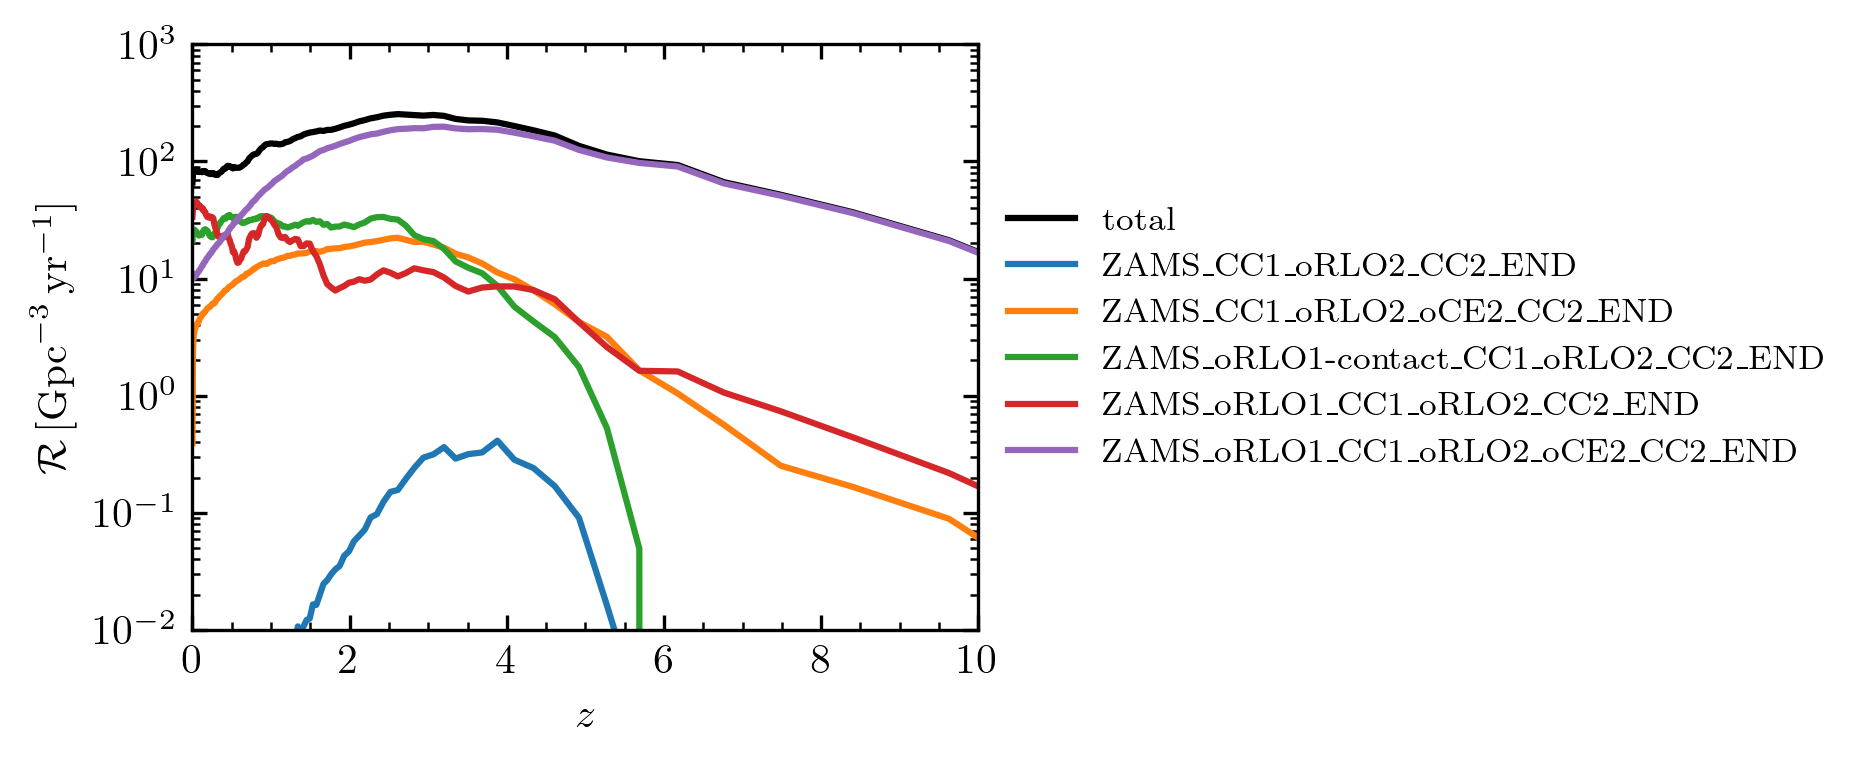

In [8]:
rates.plot_intrinsic_rate(channels=True, xlim=(0,10), ylim=(1e-2,1e3))

### Properties of the systems

Sometime syou mgiht want some more details about the actual population, and its properties.

`plot_hist_properties()` allows you to plot these.

By default, the function will create its own figure and plot it. If you would like more control over the output, you can give it your own pyplot axis and set `show=False`.
This allows you to adapt and change the plot to your liking after finishing adding the properties.

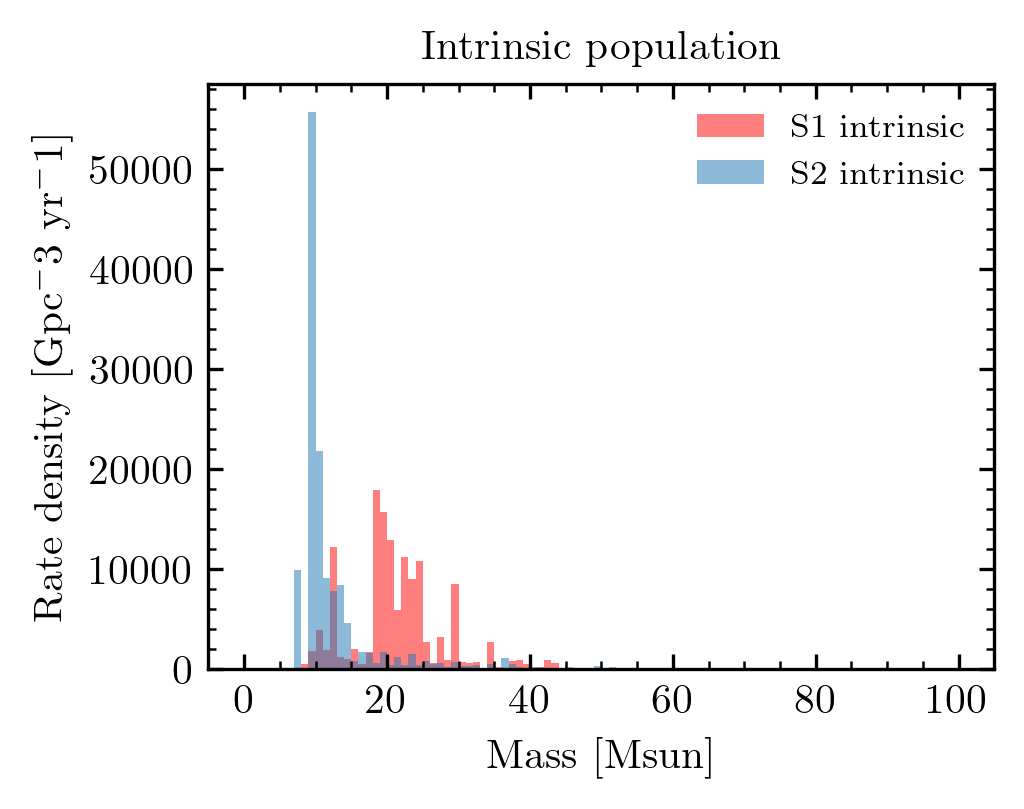

In [19]:
import numpy as np
import matplotlib.pyplot as plt

bins = np.linspace(0,100,101)
fig, ax = plt.subplots(1,1)
rates.plot_hist_properties('S1_mass', intrinsice=True, bins=bins, color='red', ax =ax, label='S1', show=False)
rates.plot_hist_properties('S2_mass', intrinsice=True, bins=bins, ax=ax, label='S2', show=False)

ax.set_ylabel('Rate density [Gpc$^-3$ yr$^-1$]')
ax.set_xlabel('Mass [Msun]')
ax.legend()
plt.show()

### observable population

Sometimes, however, you're not just interested in the intrinsic population, and want an observable population.
This could be SNe detection fraction for a telescope survey, or the LVK detection efficiency for GW mergers.

You can apply these using the `calculate_observable_population`. Similar to the `create_transient_population`, this function takes a `observable_func`, which described the observability of a transient.

An `observable_func` takes chunks of
1. TransientPopulation
2. The z_events
3. The weights

Using these, new weights are calculated.
The BBH analysis comes with a detection function for several different detector sensitivities and configurations.

In [20]:
from posydon.popsyn.transient_select_funcs import DCO_detactability

In [21]:
def DCO_wrapper(transient_chunk, z_events_chunk, weights_chunk):
    sensitivity = 'design_H1L1V1'
    return DCO_detactability(sensitivity, transient_chunk, z_events_chunk, weights_chunk, verbose=False)

In [22]:
# We also give it a name, which is used as an identifier in the file
rates.calculate_observable_population(DCO_wrapper, 'design_H1L1V1')

In [23]:
# We can now access this observable population
rates.observable_population('design_H1L1V1')

,0,1,2,3,4,5,6,7,8,9,...,128,129,130,131,132,133,134,135,136,137
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.100956,0.069479,0.031303,0.010762,0.003331,0.001043,0.000180,0.000001,0.0,0.0
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.846907,1.898609,1.297506,0.970319,0.601926,0.285329,0.061529,0.000977,0.0,0.0
2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.717202,0.775475,0.564724,0.435143,0.286504,0.141149,0.032301,0.000531,0.0,0.0
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.282646,3.284293,2.248356,1.617073,0.966810,0.447509,0.094804,0.001429,0.0,0.0
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.086130,0.104035,0.083657,0.070531,0.050556,0.026738,0.006588,0.000115,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.005848,0.007825,0.007797,0.006163,0.003821,0.001544,0.000373,0.000000,0.0,0.0
632,0.0,0.000007,0.000117,0.000369,0.000783,0.001345,0.002076,0.003025,0.004173,0.005600,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
633,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.942283,0.573267,0.339746,0.141146,0.037011,0.003295,0.000000,0.000000,0.0,0.0
634,0.0,0.000000,0.000335,0.001462,0.003440,0.006374,0.010243,0.015158,0.021148,0.028521,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


You can also plot the intrinsic and observable population together.

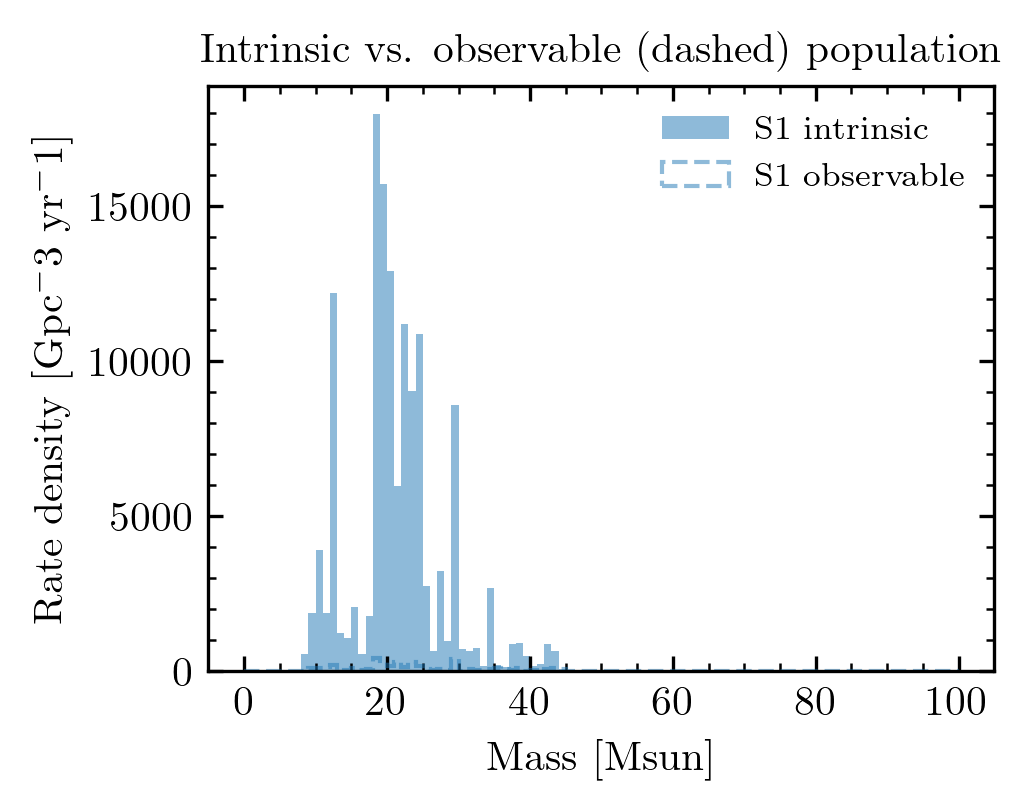

In [34]:
bins = np.linspace(0,100,101)
fig, ax = plt.subplots(1,1)

rates.plot_hist_properties('S1_mass', intrinsice=True, observable='design_H1L1V1', bins=bins, ax = ax, label='S1', show=False)
ax.set_ylabel('Rate density [Gpc$^-3$ yr$^-1$]')
ax.set_xlabel('Mass [Msun]') 
ax.legend()
plt.show()

Cogratulations, you are now ready to analyze any DCO population data you generated with POSYDON. Feel free to further explore the BBH model or to use this tutorial to study other populations.
The next tutorials show you how to [select GRBs](), perform a [SFH calculation at a single metallicity](), and [how to run an individual binary]().